In [1]:
from typing import Callable, List, Tuple, Optional, Any
from math import sqrt, inf
from enum import Enum
from copy import deepcopy
from dataclasses import dataclass

import numpy as np
import matplotlib.pyplot as plot


# Constantes

In [2]:
MAX_ITER_PADRAO = 100
DELTA_DERIVACAO_PADRAO = 10**-4
DERIVADA_SPLINE_PADRAO = 0
GRAU_SPLINE_PADRAO = 2
INDICE_SPLINE_PADRAO = 0


# Derivação numerica

In [3]:
def derivada_direita(f: Callable[[float], float], delta=DELTA_DERIVACAO_PADRAO):
    return lambda x: (f(x + delta) - f(x)) / delta


def derivada_esquerda(f: Callable[[float], float], delta=DELTA_DERIVACAO_PADRAO):
    return lambda x: (f(x - delta) - f(x)) / delta


def derivada_central(f: Callable[[float], float], delta=DELTA_DERIVACAO_PADRAO):
    return lambda x: (f(x + delta) - f(x - delta)) / (2 * delta)


# Métodos iterativos

## Calculo do erro

In [4]:
def erro_absoluto(referencia: float, estimativa: float) -> float:
    return abs(referencia - estimativa)


def erro_relativo(referencia: float, estimativa: float) -> float:
    return abs((referencia - estimativa) / estimativa)


## Classes de estado

In [5]:
@dataclass
class EstadoAB:

    f: Callable[[float], float]
    i: int
    a: float
    b: float
    x_ant: Optional[float]
    x: float
    y: float

    def __init__(
        self, f: Callable[[float], float], a: float, b: float, x: float, y: float
    ) -> None:
        self.f = f
        self.i: int = 1
        self.a = a
        self.b = b
        self.x_ant = None
        self.x = x
        self.y = y

    def __str__(self) -> str:
        return f"iteracao: {self.i}, a: {self.a}, b: {self.b}, x: {self.x}, y: {self.y}"


In [6]:
@dataclass
class EstadoX:

    f: Callable[[float], float]
    fi: Callable[[float], float]
    i: int
    x_ant: Optional[float]
    x: float
    y: float

    def __init__(
        self,
        f: Callable[[float], float],
        fi: Callable[[float], float],
        x: float,
        y: float,
    ) -> None:
        self.f = f
        self.fi = fi
        self.i: int = 1
        self.x_ant = None
        self.x = x
        self.y = y

    def __str__(self) -> str:
        return f"iteracao: {self.i}, x: {self.x}, y:{self.y}"


## Método da bisseçao

In [7]:
def bissecao(
    f: Callable[[float], float],
    a: float,
    b: float,
    criterios: list[Callable[[EstadoAB], bool]],
    observador: Callable[[EstadoAB], None] = lambda _: None,
    max_iter=MAX_ITER_PADRAO,
):
    a, b = sorted([a, b])
    x = (a + b) / 2
    est = EstadoAB(f, a, b, x, f(x))
    observador(est)
    while not all(map(lambda c: c(est), criterios)) and est.i < max_iter:
        est.i += 1
        if f(est.a) * est.y < 0:
            est.b = est.x
        else:
            est.a = est.x
        est.x_ant = est.x
        est.x = (est.a + est.b) / 2
        est.y = f(est.x)
        observador(est)
    return est


## Método da falsa posição

In [8]:
def falsa_posicao(
    f: Callable[[float], float],
    a: float,
    b: float,
    criterios: list[Callable[[EstadoAB], bool]],
    observador: Callable[[EstadoAB], None] = lambda _: None,
    max_iter=MAX_ITER_PADRAO,
):
    a, b = sorted([a, b])
    x = (a * f(b) - b * f(a)) / (f(b) - f(a))
    est = EstadoAB(f, a, b, x, f(x))
    observador(est)
    while not all(map(lambda c: c(est), criterios)) and est.i < max_iter:
        est.i += 1
        if f(est.a) * est.y < 0:
            est.b = est.x
        else:
            est.a = est.x
        est.x_ant = est.x
        est.x = (est.a * f(est.b) - est.b * f(est.a)) / (f(est.b) - f(est.a))
        est.y = f(est.x)
        observador(est)
    return est


## Método do ponto fixo

In [9]:
def ponto_fixo(
    f: Callable[[float], float],
    fi: Callable[[float], float],
    x: float,
    criterios: list[Callable[[EstadoX], bool]],
    observador: Callable[[EstadoX], None] = lambda _: None,
    max_iter=MAX_ITER_PADRAO,
):
    est = EstadoX(f, fi, x, f(x))
    observador(est)
    while not all(map(lambda c: c(est), criterios)) and est.i < max_iter:
        est.i += 1
        est.x_ant = est.x
        est.x = fi(est.x)
        est.y = f(est.x)
        observador(est)
    return est


## Método de Newtown-Raphson

In [10]:
def newton_raphson(
    f: Callable[[float], float],
    x: float,
    criterios: List[Callable[[EstadoX], bool]],
    observador: Callable[[EstadoX], None] = lambda x: None,
    max_iter=MAX_ITER_PADRAO,
):
    d = derivada_central(f)
    fi = lambda x: x - f(x) / d(x)
    return ponto_fixo(f, fi, x, criterios, observador, max_iter)


# Sistemas lineares

## Método de Gauss

In [11]:
def _multiplicar_somar(
    fator: float,
    ori: int,
    dest: int,
    b: List[List[float]],
    y: Optional[List[float]] = None,
):
    colunas = len(b[0])
    for c in range(colunas):
        b[dest][c] += fator * b[ori][c]
    if y is not None:
        y[dest] += fator * y[ori]
    pass


def _busca_pivo(linha: int, coluna: int, b: List[List[float]]):
    maior = -inf
    posicao = -1
    for l in range(linha, len(b)):
        valor = abs(b[l][coluna])
        if valor > maior:
            maior = valor
            posicao = l
    return posicao


def _elimininacao_gauss(
    linha: int, coluna: int, b: List[List[float]], y: Optional[List[float]] = None
):
    for l in range(linha + 1, len(b)):
        fator = b[l][coluna] / b[linha][coluna]
        _multiplicar_somar(-fator, linha, l, b, y)
    pass


def gauss(
    b: List[List[float]], y: Optional[List[float]] = None
) -> Tuple[List[List[float]], Optional[List[float]]]:
    b, y = deepcopy(b), deepcopy(y)
    l, c = 0, 0
    m, n = len(b), len(b[0])
    while l < m and c < n:
        linha_pivo = _busca_pivo(l, c, b)
        if linha_pivo != -1:
            b[l], b[linha_pivo] = b[linha_pivo], b[l]
            if y is not None:
                y[l], y[linha_pivo] = y[linha_pivo], y[l]
            _elimininacao_gauss(l, c, b, y)
            l += 1
            c += 1
        else:
            c += 1
    return b, y


## Tipo Solução

In [12]:
class TipoSolucao(Enum):
    NENHUMA = 0
    UNICA = 1
    MULTIPLAS = 2


def tipo_solucao(b, y) -> TipoSolucao:
    for i in range(len(b)):
        if b[i][i] == 0.0:
            if y[i] == 0.0:
                return TipoSolucao.MULTIPLAS
            else:
                return TipoSolucao.NENHUMA
    return TipoSolucao.UNICA


## Substituição Retroativa

In [13]:
def substituicao_retroativa(b: List[List[float]], y: List[float]) -> List[float]:
    if tipo_solucao(b, y) != TipoSolucao.UNICA:
        raise ValueError("a matriz dada não adimite solução unica")
    n = len(y)
    x = [0.0] * n
    for i in reversed(range(n)):
        s = sum(b[i][j] * x[j] for j in range(i + 1, n))
        x[i] = (y[i] - s) / b[i][i]
    return x


## Solucionar sistema

In [14]:
def solucionar_linear(b: List[List[float]], y: List[float]):
    b, y = gauss(b, y)  # type: ignore
    x = substituicao_retroativa(b, y)
    return x


## Gauss-Seidel

In [15]:
@dataclass
class EstadoGauss:

    i: int
    x_ant: Optional[List[float]]
    x: List[float]

    def __init__(self, x: List[float]) -> None:
        self.i = 1
        self.x_ant = None
        self.x = x


In [16]:
def _passo_gauss_seidel(
    b: List[List[float]],
    y: List[float],
    x: List[float],
) -> List[float]:
    n = len(x)
    proximo_x = [0.0] * n
    for i in range(n):
        soma_esquerda = sum(b[i][j] * x[j] for j in range(i))
        soma_direita = sum(b[i][j] * x[j] for j in range(i + 1, n))
        proximo_x[i] = (y[i] - soma_esquerda - soma_direita) / b[i][i]
    return proximo_x


def gauss_seidel(
    b: List[List[float]],
    y: List[float],
    x_inicial: List[float],
    criterios: List[Callable[[EstadoGauss], bool]],
    observador: Callable[[EstadoGauss], None] = lambda _: None,
    max_iter=MAX_ITER_PADRAO,
) -> EstadoGauss:
    estado = EstadoGauss(deepcopy(x_inicial))
    while not all(c(estado) for c in criterios) and estado.i < max_iter:
        estado.i += 1
        estado.x_ant = estado.x
        estado.x = _passo_gauss_seidel(b, y, estado.x)
    return estado


## Gauss-Jacob

In [17]:
def _passo_gauss_jacob(
    b: List[List[float]],
    y: List[float],
    x: List[float],
) -> List[float]:
    n = len(x)
    proximo_x = [0.0] * n
    for i in range(n):
        soma_esquerda = sum(b[i][j] * proximo_x[j] for j in range(i))
        soma_direita = sum(b[i][j] * x[j] for j in range(i + 1, n))
        proximo_x[i] = (y[i] - soma_esquerda - soma_direita) / b[i][i]
    return proximo_x


def gauss_jacob(
    b: List[List[float]],
    y: List[float],
    x_inicial: List[float],
    criterios: List[Callable[[EstadoGauss], bool]],
    observador: Callable[[EstadoGauss], None] = lambda _: None,
    max_iter=MAX_ITER_PADRAO,
) -> EstadoGauss:
    estado = EstadoGauss(deepcopy(x_inicial))
    while not all(c(estado) for c in criterios) and estado.i < max_iter:
        estado.i += 1
        estado.x_ant = estado.x
        estado.x = _passo_gauss_jacob(b, y, estado.x)
    return estado


# Interpolação

## Polinômio de Lagrange

In [18]:
from math import prod


def _termo_lagrange(xs: List[float], ys: List[float], x: float, i: int) -> float:
    n = len(xs)
    produto_superior = prod(x - xs[j] for j in range(n) if j != i)
    produto_inferior = prod(xs[i] - xs[j] for j in range(n) if j != i)
    return (produto_superior / produto_inferior) * ys[i]


def polinomio_lagrange(xs: List[float], ys: List[float]) -> Callable[[float], float]:
    xs = deepcopy(xs)
    ys = deepcopy(ys)
    return lambda x: sum(_termo_lagrange(xs, ys, x, i) for i in range(len(xs)))


## Polinômio de Newton

In [19]:
def diferencas_divididas(xs: List[float], ys: List[float]) -> List[float]:
    assert len(xs) == len(ys), "xs e ys devem ter o mesmo comprimento"
    n = len(xs)
    m = [[0.0] * (n - i) for i in range(n)]
    for i in range(n):
        m[i][0] = ys[i]
    for j in range(1, n):
        for i in range(n - j):
            m[i][j] = (m[i + 1][j - 1] - m[i][j - 1]) / (xs[i + j] - xs[i])
    return m[0]


def _termo_newton(xs: List[float], dif_divs: List[float], x: float, i: int) -> float:
    return dif_divs[i] * prod(x - xs[j] for j in range(i))


def polinomio_newton(xs: List[float], ys: List[float]):
    xs = deepcopy(xs)
    dif_divs = diferencas_divididas(xs, ys)
    return lambda x: sum(_termo_newton(xs, dif_divs, x, i) for i in range(len(xs)))


## Spline quadrática

In [20]:
_ESQUERDA = 0
_DIREITA = 1


def _polinomio(coefs: List[float]) -> Callable[[float], float]:
    coefs = deepcopy(coefs)
    return lambda x: sum(coefs[i] * x**i for i in range(len(coefs)))


def _linha(x: float, grau: int = 0) -> List[float]:
    match grau:
        case 0:
            return [1.0, x, x**2]
        case 1:
            return [0, 1.0, 2 * x]
        case 2:
            return [0.0, 0.0, 2.0]
        case _:
            raise ValueError(f"valor de grau {grau} invalido")


def _valor_derivada(coefs: List[float], x: float) -> float:
    return sum(i * x ** (i - 1) * coefs[i] for i in range(1, len(coefs)))


def _segmento_spline(
    xs: List[float],
    ys: List[float],
    derivada: float,
    grau: int,
    indice: int,
    lado: int,
) -> List[float]:
    x = [
        _linha(xs[indice]),
        _linha(xs[indice + 1]),
        _linha(xs[indice + lado], grau),
    ]
    y = [ys[indice], ys[indice + 1], derivada]
    return solucionar_linear(x, y)


def coeficientes_spline_quadratica(
    xs: List[float],
    ys: List[float],
    derivada: float = DERIVADA_SPLINE_PADRAO,
    grau: int = GRAU_SPLINE_PADRAO,
    indice: int = INDICE_SPLINE_PADRAO,
) -> List[List[float]]:
    assert len(xs) == len(ys), "xs e ys devem ter o mesmo comprimento"
    assert grau in [1, 2], "grau inválido"
    assert 0 <= indice, "indice não pode ser menor que 0"
    assert indice < len(xs), "indice não pode ser menor que len(ys)"
    lista_coefs: List[List[float]] = [[]] * (len(xs) - 1)
    # Resolve os coeficientes para as funções a esquerda
    d = derivada
    g = grau
    for i in range(indice - 1, -1, -1):
        coefs = _segmento_spline(xs, ys, d, g, i, _DIREITA)
        lista_coefs[i] = coefs
        d = _valor_derivada(coefs, xs[i])
        g = 1
    # Resolve os coeficientes para as funções a direita
    if indice == 0:
        d = derivada
        g = grau
    else:
        d = _valor_derivada(lista_coefs[indice - 1], xs[indice])
        g = 1
    for i in range(indice, len(xs) - 1):
        coefs = _segmento_spline(xs, ys, d, g, i, _ESQUERDA)
        lista_coefs[i] = coefs
        d = _valor_derivada(coefs, xs[i + 1])
        g = 1
    return lista_coefs


def spline_quadratica(
    xs: List[float],
    ys: List[float],
    derivada: float = DERIVADA_SPLINE_PADRAO,
    grau: int = GRAU_SPLINE_PADRAO,
    indice: int = INDICE_SPLINE_PADRAO,
) -> Callable[[float], float]:
    xs = deepcopy(xs)
    lista_coefs = coeficientes_spline_quadratica(xs, ys, derivada, grau, indice)
    fs = [_polinomio(coefs) for coefs in lista_coefs]

    def interpolador(x):
        for i in range(len(xs) - 1):
            if x < xs[i + 1]:
                return fs[i](x)
        return fs[-1](x)

    return interpolador


# Ajuste de curvas

## Minimos quadrados

In [21]:
def _produto_escalar(a: List[float], b: List[float]):
    return sum(i * j for i, j in zip(a, b))


def coeficientes_minimos_quadrados(
    xs: List[float],
    ys: List[float],
    fs: List[Callable[[float], float]],
) -> List[float]:
    assert len(xs) == len(ys), "xs e ys devem ter o mesmo comprimento"
    n = len(fs)
    gs = [[f(x) for x in xs] for f in fs]
    b = [[_produto_escalar(gs[i], gs[j]) for i in range(n)] for j in range(n)]
    y = [_produto_escalar(gs[i], ys) for i in range(n)]
    return solucionar_linear(b, y)


def minimos_quadrados(
    xs: List[float],
    ys: List[float],
    fs: List[Callable[[float], float]],
):
    coefs = coeficientes_minimos_quadrados(xs, ys, fs)
    return lambda x: sum(c * f(x) for c, f in zip(coefs, fs))


def soma_quadrado_residuos(
    xs: List[float],
    ys: List[float],
    f: Callable[[float], float],
) -> float:
    return sum((y - f(x)) ** 2 for x, y in zip(xs, ys))


# Condições de parada

In [22]:
def limite_iteracao(i: int) -> Callable[[Any], bool]:
    return lambda est: est.i >= i


def criterio_erro_absoluto(
    ref: float,
    erro_max: float,
) -> Callable[[EstadoAB | EstadoX], bool]:
    return lambda est: erro_absoluto(ref, est.x) < erro_max


def criterio_ab(erro_max: float) -> Callable[[EstadoAB], bool]:
    return lambda est: est.b - est.a < 2 * erro_max


def criterio_x(erro_max: float) -> Callable[[EstadoAB | EstadoX], bool]:
    return lambda est: est.f(est.x - erro_max) * est.f(est.x + erro_max) < 0


def criterio_delta_x(delta: float) -> Callable[[EstadoAB | EstadoX], bool]:
    return lambda est: est.x_ant is not None and abs(est.x - est.x_ant) < delta


def criterio_y(dist_zero: float) -> Callable[[EstadoAB | EstadoX], bool]:
    return lambda est: abs(est.y) < dist_zero


def criterio_delta_x_vetor(delta: float) -> Callable[[EstadoGauss], bool]:
    return lambda est: est.x_ant is not None and all(
        (abs(i - j) < delta) for i, j in zip(est.x_ant, est.x)
    )


# Amostras

In [23]:
def amostra_linear(x):
    return 2 * x + 2


def amostra_poli(x):
    return x**2 + x - 6


def amostra_poli_iter(x):
    return sqrt(6 - x)


amostra_b = [
    [9.0, 2.0, 1.0],
    [5.0, 7.0, 2.0],
    [6.0, 2.0, 11.0],
]

amostra_y = [3.0, 3.0, 1.0]

amostra_xs = [1.0, 4.0, 7.0, 8.0, 11.0]
amostra_ys = [2.0, 5.0, 3.0, 4.0, 1.0]


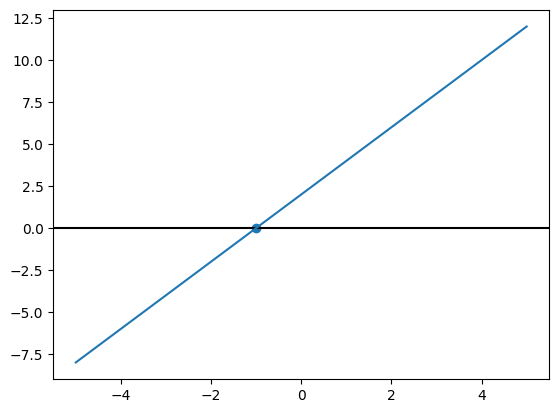

In [24]:
x = np.linspace(-5, 5)
y = np.vectorize(amostra_linear)(x)
res = bissecao(amostra_linear, -3, 3, [criterio_ab(10**-4)])
_ = plot.axhline(0, color="k")
_ = plot.plot(x, y)
_ = plot.scatter([res.x], [res.y])


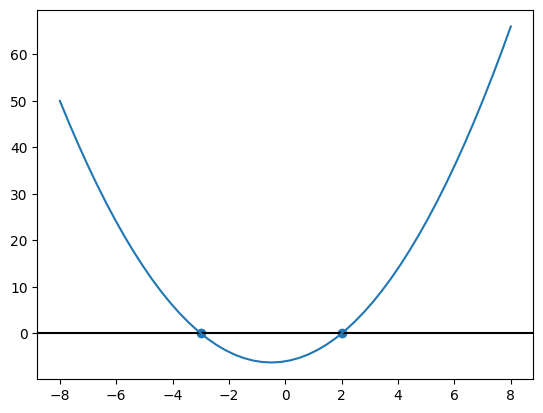

In [25]:
x = np.linspace(-8, 8)
y = np.vectorize(amostra_poli)(x)
res_1 = newton_raphson(amostra_poli, -2, [criterio_x(10**-4)])
res_2 = newton_raphson(amostra_poli, 4, [criterio_x(10**-4)])
_ = plot.axhline(color="k")
_ = plot.plot(x, y)
_ = plot.scatter([res_1.x, res_2.x], [res_1.y, res_2.y])


In [26]:
x = solucionar_linear(amostra_b, amostra_y)
print(x)


[0.2894248608534323, 0.2541743970315399, -0.1131725417439703]


In [27]:
x_inicial = [1.0, 1.0, 1.0]
res = gauss_seidel(amostra_b, amostra_y, x_inicial, [criterio_delta_x_vetor(10**-4)])
print(res.x)


[0.28944322078332885, 0.25420971804947057, -0.11314490853281187]


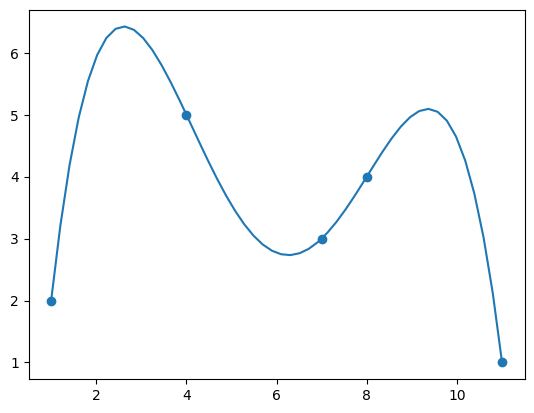

In [28]:
x = np.linspace(1, 11)
f = polinomio_lagrange(amostra_xs, amostra_ys)
y = np.vectorize(f)(x)
_ = plot.scatter(amostra_xs, amostra_ys)
_ = plot.plot(x, y)


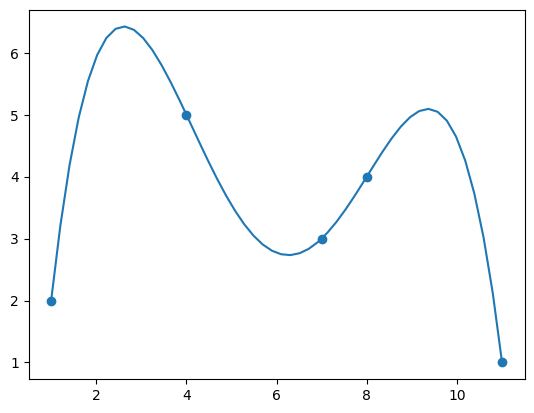

In [29]:
x = np.linspace(1, 11)
f = polinomio_newton(amostra_xs, amostra_ys)
y = np.vectorize(f)(x)
_ = plot.scatter(amostra_xs, amostra_ys)
_ = plot.plot(x, y)


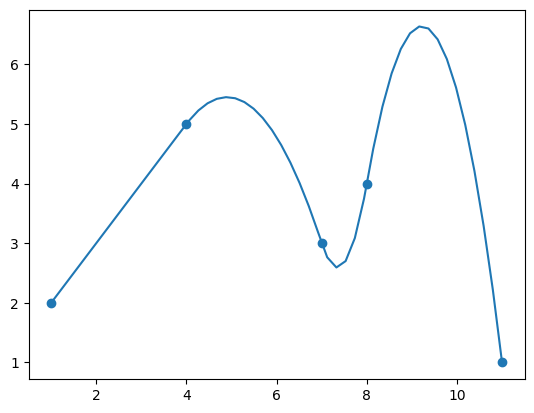

In [30]:
x = np.linspace(1, 11)
f = spline_quadratica(amostra_xs, amostra_ys, indice=1)
y = np.vectorize(f)(x)
_ = plot.scatter(amostra_xs, amostra_ys)
_ = plot.plot(x, y)


erro: 2.1000837520937994


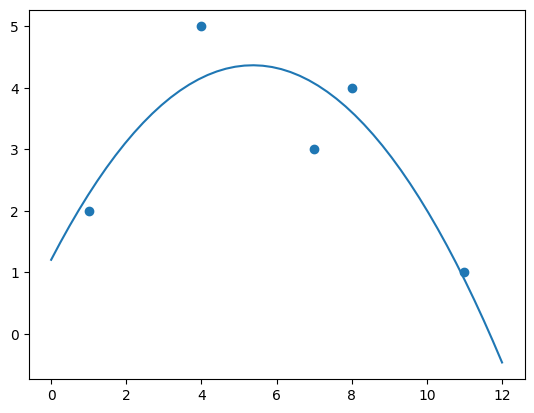

In [31]:
fs = [lambda x: 1, lambda x: x, lambda x: x**2]
f = minimos_quadrados(amostra_xs, amostra_ys, fs)
x = np.linspace(0, 12)
y = np.vectorize(f)(x)
_ = plot.scatter(amostra_xs, amostra_ys)
_ = plot.plot(x, y)
erro = soma_quadrado_residuos(amostra_xs, amostra_ys, f)
print(f"erro: {erro}")


# Playground 

### Questão 1

In [32]:
xs = [-2.0, -1.0, 1.0, 2.0]
ys = [5.0, 0.0, -1.0, 5.0]


#### a)

In [33]:
coefs = diferencas_divididas(xs, ys)
print("coefs newton:", coefs)


coefs newton: [5.0, -5.0, 1.5, 0.16666666666666663]


#### b)

In [34]:
coefs = coeficientes_spline_quadratica(xs, ys, derivada=-5, indice=0, grau=1)
print("coefs spline quadratica:", coefs)


coefs spline quadratica: [[-5.0, -5.0, -0.0], [-2.75, -0.5, 2.25], [-3.0, 0.0, 2.0]]


#### c)

### Questão 2

In [35]:
xs = [-0.9, -0.6, -0.3, 0.0, 0.3, 0.6, 0.9]
ys = [0.64, 1.06, 1.57, 1.91, 1.61, 1.07, 0.64]


In [36]:
zs_1 = [1 / y for y in ys]
fs_1 = [lambda x: x**2, lambda _: 1]
c_1, c_2 = coeficientes_minimos_quadrados(xs, zs_1, fs_1)
print("coefs 1 linear:", [c_1, c_2])
a = 1 / c_1
b = c_2 * a
print("coefs 1:", [a, b])


coefs 1 linear: [1.2905525263966768, 0.5046291708790691]
coefs 1: [0.7748619134411195, 0.3910179249255612]


In [37]:
f_1 = lambda x: a / (x**2 + b)
erro_1 = soma_quadrado_residuos(xs, ys, f_1)
print("erro phi_1:", erro_1)


erro phi_1: 0.00912083493577429


In [38]:
from math import log, exp

zs_2 = [log(y) for y in ys]
fs_2 = [lambda _: 1, lambda x: x**2]
c_1, c_2 = coeficientes_minimos_quadrados(xs, zs_2, fs_2)
print("coefs 2 linear:", [c_1, c_2])
a = c_1
b = c_2
print("coefs 2:", [a, b])


coefs 2 linear: [0.5836434554693499, -1.3006896017973695]
coefs 2: [0.5836434554693499, -1.3006896017973695]


In [39]:
f_2 = lambda x: exp(a + b * x**2)
erro_2 = soma_quadrado_residuos(xs, ys, f_2)
print("erro phi_2:", erro_2)


erro phi_2: 0.021700953869857313
